# Modeling relative strain prevalence

This notebook explores Pyro models for forecasting relative strain prevalance based on GISAID sequence data labeled with Pangolin lineage and amino acid mutation features.

In [1]:
import math
import pickle
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoNormal, init_to_median
from pyro.infer.reparam import HaarReparam
from pyro.optim import Adam, ClippedAdam
from pyrocov import pangolin
from pyrocov.geo import gisaid_to_jhu_location, parse_date, pd_to_torch, read_csv

matplotlib.rcParams['figure.dpi'] = 200

## Loading data

We'll use all GISAID data. You'll need to request a feed from gisaid.org, download, then run
```sh
python preprocess_gisaid.py
nextclade --input-fasta results/gisaid.subset.fasta \
          --output-tsv results/gisaid.subset.tsv
python featurize_nextclade.py
```

In [2]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Training on {} rows with columns:".format(len(columns["day"])))
print(", ".join(columns.keys()))

Training on 715318 rows with columns:
accession_id, collection_date, location, add_location, lineage, day


In [3]:
lineages = list(map(pangolin.compress, columns["lineage"]))
print(f"Top 12 of {len(set(lineages))} lineages")
print("-" * 30)
for lineage, count in Counter(lineages).most_common(12):
    print(f"{count: >10d} {lineage}")

Top 12 of 880 lineages
------------------------------
    144992 B.1.1.7
     92250 B.1.177
     60184 B.1
     51615 B.1.2
     21414 B.1.1.29
     18772 B.1.160
     12353 D.2
      9401 B.1.177.21
      8409 C
      8196 B.1.258
      8103 B.1.221
      7617 B.1.1.284


In [4]:
locations = columns["location"]
print(f"Top 12 of {len(set(locations))} GISAID locations")
print("-" * 30)
for location, count in Counter(locations).most_common(12):
    print(f"{count: >10d} {location}")

Top 12 of 7015 GISAID locations
------------------------------
    225318 Europe / United Kingdom / England
     29619 Europe / United Kingdom / Wales
     21564 Europe / Denmark / Hovedstaden
     20522 Asia / Japan
     19403 Europe / United Kingdom / Scotland
     18549 North America / USA / Texas / Houston
     13654 Oceania / Australia / Victoria
      8462 Europe / Denmark / Syddanmark
      8018 North America / USA / California
      7797 North America / USA / Michigan
      7534 Europe / Denmark / Midtjylland
      6713 Europe / Denmark / Sjaelland


In [5]:
aa_features = torch.load("results/nextclade.features.pt")
print(aa_features.keys())

dict_keys(['lineages', 'mutations', 'features'])


In [6]:
print(aa_features["features"].shape)

torch.Size([880, 10011])


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

In [7]:
us_cases_df = read_csv("time_series_covid19_confirmed_US.csv")
global_cases_df = read_csv("time_series_covid19_confirmed_global.csv")
case_data = torch.cat([
    pd_to_torch(us_cases_df, columns=slice(11, None)),
    pd_to_torch(global_cases_df, columns=slice(4, None)),
]).T
sample_region, sample_matrix, region_tuples = gisaid_to_jhu_location(
    columns, us_cases_df, global_cases_df
)
num_gisaid_regions, num_jhu_regions = sample_matrix.shape

In [8]:
print(case_data.shape)
print(sample_region.shape)
print(sample_matrix.shape)
print(len(set(columns['location'])))
print(len(columns['location']))

torch.Size([413, 3614])
torch.Size([715318])
torch.Size([7015, 3614])
7015
715318


## Aggregating regions

We'll aggregate locations by either US state, UK regions, or other country.

In [9]:
TIMESTEP = 14  # Reasonable values might be week, fortnight, or month.
features = aa_features["features"]
lineages = list(map(pangolin.compress, columns["lineage"]))
lineage_id_inv = list(map(pangolin.compress, aa_features["lineages"]))
lineage_id = {k: i for i, k in enumerate(lineage_id_inv)}

In [10]:
sparse_data = Counter()
location_id = {}
quotient = {}
for day, location, lineage in zip(columns["day"], columns["location"], lineages):
    parts = location.split("/")
    if len(parts) < 2:
        continue
    parts = [p.strip() for p in parts[:3]]
    if parts[1] not in ("USA", "United Kingdom"):
        parts = parts[:2]
    quotient[location] = " / ".join(parts)
    p = location_id.setdefault(quotient[location], len(location_id))
    s = lineage_id[lineage]
    t = day // TIMESTEP
    sparse_data[t, p, s] += 1

In [11]:
T = 1 + max(columns["day"]) // TIMESTEP
P = len(location_id)
S = len(lineage_id)
weekly_strains = torch.zeros(T, P, S)
for (t, p, s), n in sparse_data.items():
    weekly_strains[t, p, s] = n
print(weekly_strains.shape, weekly_strains.shape.numel())

torch.Size([33, 229, 880]) 6650160


In [12]:
quotient_matrix = torch.zeros(len(location_id), num_jhu_regions)
gisaid_id = {k: i for i, k in enumerate(sorted(quotient))}
for g, q in quotient.items():
    quotient_matrix[location_id[q]] += sample_matrix[gisaid_id[g]]
count_data = case_data @ quotient_matrix.T

Convert from daily to weekly observations.

In [13]:
start_date = parse_date("12/01/19")
jhu_start_date = parse_date(us_cases_df.columns[11])
assert start_date < jhu_start_date
dt = (jhu_start_date - start_date).days
weekly_cases = torch.zeros(T, P)
for w in range(TIMESTEP):
    t0 = (w + dt) // TIMESTEP
    source = count_data[w::TIMESTEP]
    destin = weekly_cases[t0:t0+len(source)]
    destin[:] += source[:len(destin)]
assert weekly_cases.sum() > 0
print(weekly_cases.shape)

torch.Size([33, 229])


Heuristically estimate the number of infections. This need not be very accurate.

In [14]:
response_rate = 0.05
weekly_infections = torch.maximum(weekly_cases, weekly_strains.sum(-1)) / response_rate
weekly_infections.clamp_(min=1);

## Constructing a Pyro model

Our first model is a logistic growth model with a Dirichlet-multinomial likelihood (the multivariate generalization of negative binomial likelihood). This ignores any spatial structure across regions.

In [15]:
def model(weekly_strains, weekly_infections, features, feature_scale=1.0,
          noisy=False):
    assert weekly_strains.shape[-1] == features.shape[0]
    assert weekly_infections.shape == weekly_strains.shape[:2]
    T, P, S = weekly_strains.shape
    S, F = features.shape
    time_plate = pyro.plate("time", T, dim=-2)
    dtime_plate = pyro.plate("dtime", T - 1, dim=-2)
    place_plate = pyro.plate("place", P, dim=-1)
    time = torch.arange(float(T)) * TIMESTEP / 365.25  # in years
    time -= time.max()

    # Assume relative growth rate depends on mutation features but not time or place.
    log_rate_coef = pyro.sample(
        "log_rate_coef", dist.Laplace(0, feature_scale).expand([F]).to_event(1)
    )
    log_rate = pyro.deterministic("log_rate", log_rate_coef @ features.T)

    # Assume places differ only in their initial infection count.
    with place_plate:
        log_init = pyro.sample(
            "log_init", dist.Normal(0, 10).expand([S]).to_event(1)
        )
    logits = log_init + log_rate * time[:, None, None]

    # Optionally add process noise corresponding to epidemiological randomness.
    if noisy:
        # Noise depends on time, place, and strain, but with a shared scale.
        with time_plate, place_plate:
            rep = HaarReparam(dim=-3, experimental_allow_batch=True)
            # Sample noise from near uniform, encoding the prior as a factor graph.
            with poutine.reparam(config={"noise": rep}), poutine.scale(scale=1/T):
                noise = pyro.sample(
                    "noise", dist.Normal(0, 1).expand([T, P, S]).to_event(1)
                )
        logits = logits + noise
    strain_probs = logits.softmax(-1)
    strain_counts = pyro.deterministic(
        "strain_counts", (weekly_infections[..., None] * strain_probs).clamp(min=1e-3)
    )
    
    if noisy:
        # This is moment-matched to Poisson noise as in a discrete-state Markov chain.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(0, 1))
        noise_scale = noise_scale * strain_counts[:-1].reciprocal().log1p().sqrt()
        with dtime_plate, place_plate:
            pyro.sample(
                "dynamics",
                dist.Normal(0, noise_scale).to_event(1),
                obs=noise[1:] - noise[:-1],
            )

    # Finally observe overdispersed counts.
    strain_probs = logits.softmax(-1) if strain_probs is None else strain_probs
    concentration = pyro.sample("concentration", dist.LogNormal(2, 4))
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.DirichletMultinomial(
                total_count=weekly_strains.sum(-1).max(),
                concentration=concentration * strain_probs,
                is_sparse=True,  # uses a faster algorithm
            ),
            obs=weekly_strains,
        )

## Fitting the model

We'll use simple MAP estimation via Pyro's SVI and an `AutoDelta` guide. I'm defining a custom initialization function to initialize forecasts to uniformly even rather than random.

In [16]:
def init_loc_fn(site):
    if site["name"] in ("log_rate_coef", "log_rate", "log_init", "noise", "noise_haar"):
        return torch.zeros(site["fn"].shape())
    if site["name"].endswith("noise_scale"):
        return torch.full(site["fn"].shape(), 3.0)
    if site["name"] == "concentration":
        return torch.full(site["fn"].shape(), 5.0)
    return init_to_median(site)

First let's train a simple linear-logistic model with no process noise.

Next let's add process noise. This model has many more parameters, so we expect improved fit. One way to assess fit is the learned concentration paramter: better fitting models should have higher concentration parameter, indicating tighter fit between predictions and observations.

Training guide with 211532 parameters:
step    0 loss = 23.3	conc. = 5.26	noise. = 0	
step   10 loss = 22.3	conc. = 6.21	noise. = 0	
step   20 loss = 21.7	conc. = 7.37	noise. = 0	
step   30 loss = 21.3	conc. = 8.46	noise. = 0	
step   40 loss = 21.1	conc. = 9.16	noise. = 0	
step   50 loss = 20.9	conc. = 9.78	noise. = 0	
step   60 loss = 20.8	conc. = 10.7	noise. = 0	
step   70 loss = 20.7	conc. = 11.8	noise. = 0	
step   80 loss = 20.6	conc. = 13.1	noise. = 0	
step   90 loss = 20.6	conc. = 14.7	noise. = 0	
step  100 loss = 20.5	conc. = 16.7	noise. = 0	
step  110 loss = 20.4	conc. = 18.6	noise. = 0	
step  120 loss = 20.4	conc. = 20.9	noise. = 0	
step  130 loss = 20.4	conc. = 23.1	noise. = 0	
step  140 loss = 20.3	conc. = 25	noise. = 0	
step  150 loss = 20.3	conc. = 26.6	noise. = 0	
step  160 loss = 20.3	conc. = 27.7	noise. = 0	
step  170 loss = 20.3	conc. = 28.7	noise. = 0	
step  180 loss = 20.2	conc. = 30.1	noise. = 0	
step  190 loss = 20.2	conc. = 30.2	noise. = 0	
step  200 loss = 20.2	c

Text(0, 0.5, 'loss')

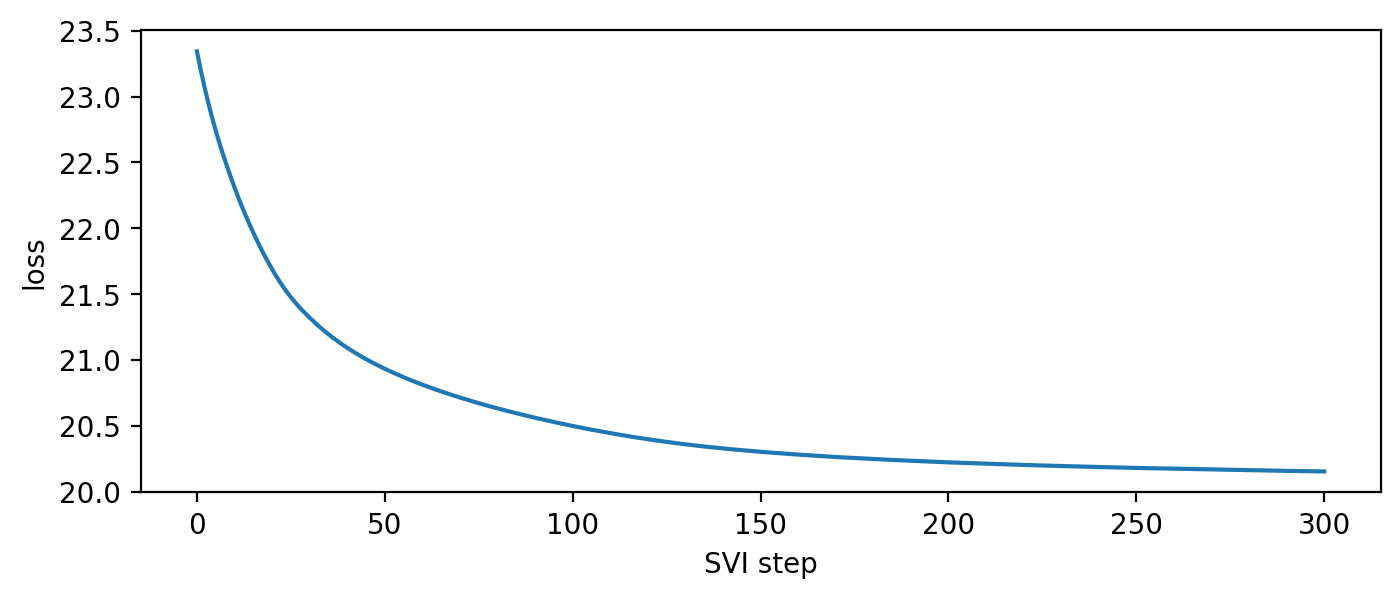

In [17]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(20210309)

guide = AutoDelta(model, init_loc_fn=init_loc_fn)
# Initialize guide so we can count parameters.
guide(weekly_strains, weekly_infections, features)
print("Training guide with {} parameters:".format(sum(p.numel() for p in guide.parameters())))
optim = ClippedAdam({"lr": 0.05, "betas": (0.8, 0.99)})
svi = SVI(model, guide, optim, Trace_ELBO())
losses = []
num_obs = weekly_strains.count_nonzero()
for step in range(301):
    loss = svi.step(weekly_strains, weekly_infections, features) / num_obs
    assert not math.isnan(loss)
    losses.append(loss)
    if step % 10 == 0:
        median = guide.median()
        concentration = median["concentration"].item()
        noise_scale = float(median.get("noise_scale", 0.0))
        print(f"step {step: >4d} loss = {loss:0.3g}\t"
              f"conc. = {concentration:0.3g}\t"
              f"noise. = {noise_scale:0.3g}\t")

plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss");

After fitting, we can extract a point estimate via the `guide.median()` method, which returns a dict.

In [18]:
with torch.no_grad():
    median = {k: v.detach() for k, v in guide.median().items()}
median["log_rate"] = median["log_rate_coef"] @ features.T
print(", ".join(median.keys()))

log_rate_coef, log_init, concentration, log_rate


## Interpreting results

Since we're fitting relative growth rate and prevalence, we can characterize all lineages by these quantities. Note the relative transmissibility looks suspciously diverse, suggesting we should probably add process noise to our model.

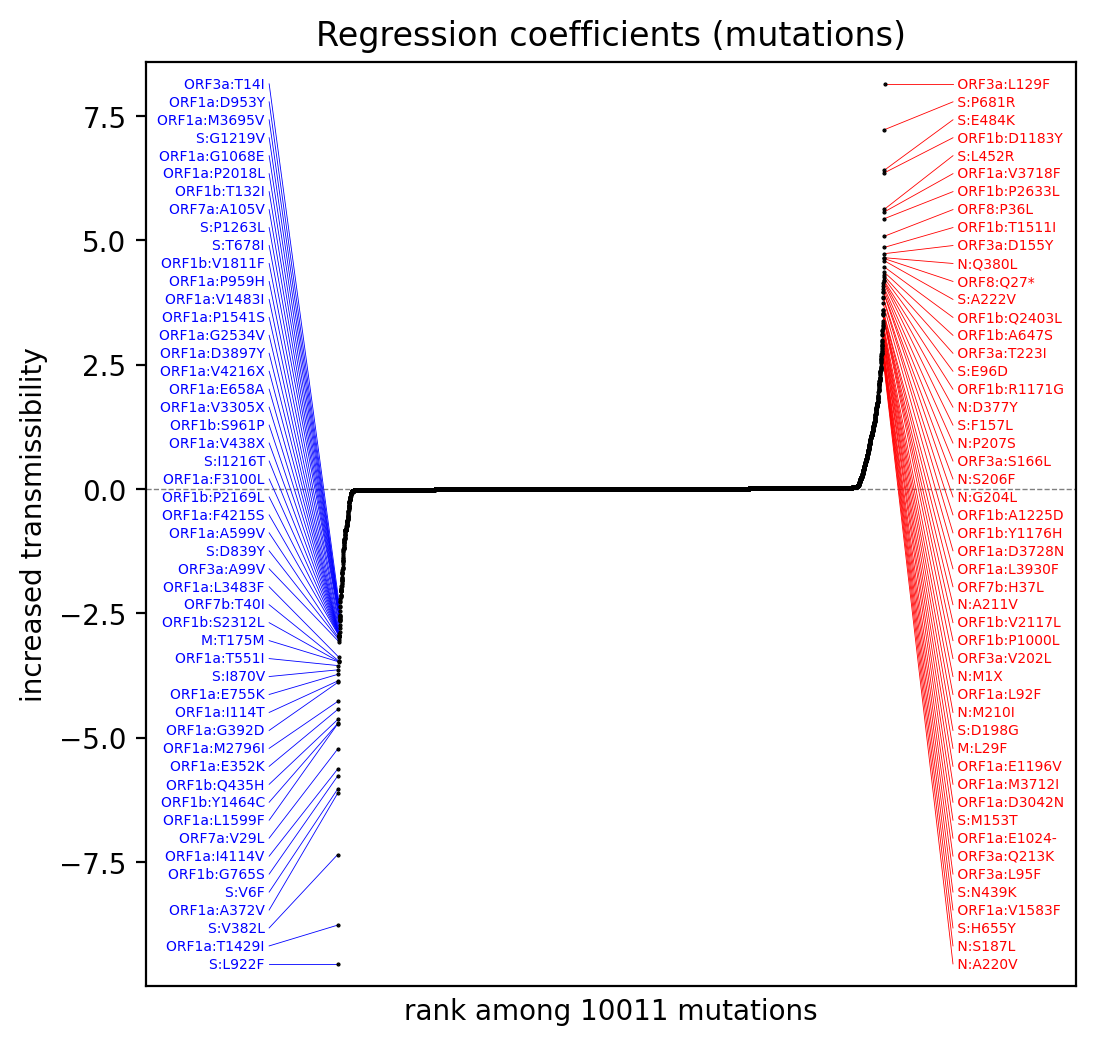

In [19]:
mutations = aa_features['mutations']
xs, idx = median["log_rate_coef"].sort(0)
assert len(idx) == len(mutations)
plt.figure(figsize=(6, 6))
plt.title("Regression coefficients (mutations)")
plt.plot(xs, 'k.', lw=0, markersize=1, zorder=10)
plt.axhline(0, color='black', lw=0.5, linestyle='--', alpha=0.5)
plt.xlabel(f"rank among {len(xs)} mutations")
plt.ylabel("increased transmissibility")

I = len(idx)
y0 = float(xs.min())
y1 = float(xs.max())
N = 50
for i in range(N):
    x = -I / 8
    y = y0 + (y1 - y0) * i / (N - 1)
    plt.plot([i, x], [xs[i], y], color='blue', lw=0.3)
    plt.text(x, y, mutations[int(idx[i])] + " ", fontsize=5, color='blue',
             verticalalignment="center", horizontalalignment="right")
for i in range(I - N, I):
    x = I + I / 8
    y = y1 + (y0 - y1) * (I - i - 1) / (N - 1)
    plt.plot([i, x], [xs[i], y], color='red', lw=0.3)
    plt.text(x, y, " " + mutations[int(idx[i])], fontsize=5, color='red',
             verticalalignment="center", horizontalalignment="left")
plt.ylim(y0 - (y1 - y0) / 40, y1 + (y1 - y0) / 40)
plt.xlim(-0.35 * I, 1.35 * I)
# plt.yticks(())
plt.xticks(());

We can also examine coefficients of some known mutations.

In [20]:
for name in ["N501Y", "D614G"]:
    i, = [i for i, m in enumerate(mutations) if name in m]
    coef = float(median["log_rate_coef"][i])
    print(f"{name} increases transmissibility by {coef:0.3g}")

N501Y increases transmissibility by 2.17
D614G increases transmissibility by 1.36


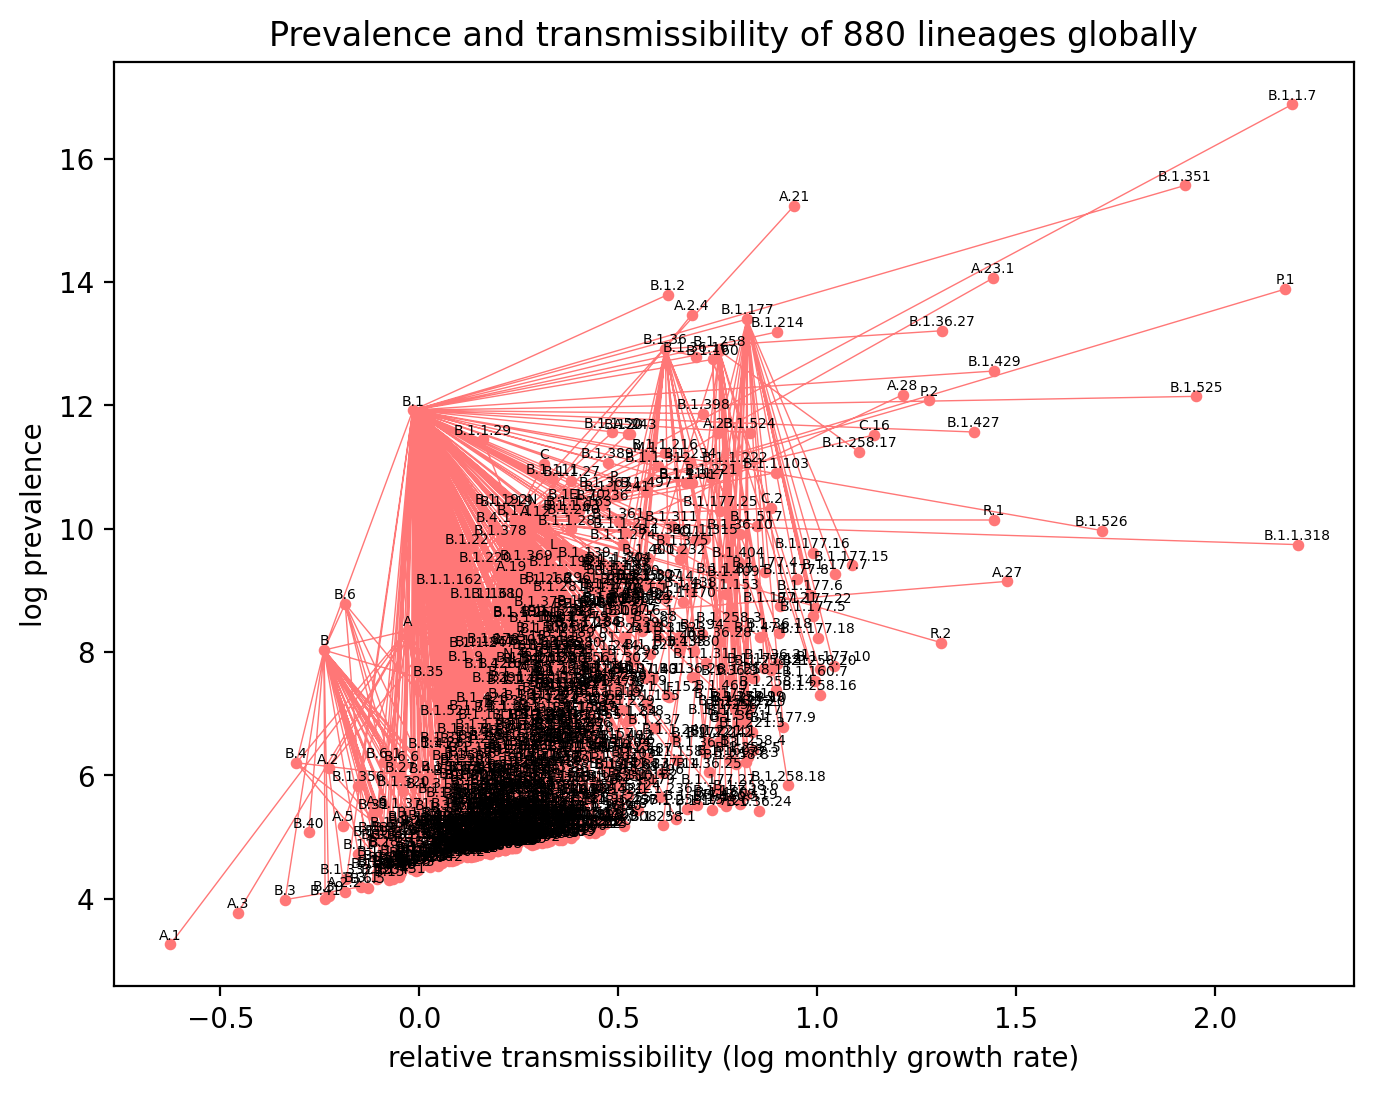

In [21]:
edges = pangolin.find_edges(list(lineage_id))
edges = torch.tensor([[lineage_id[u], lineage_id[v]] for u, v in edges], dtype=torch.long)

def plot_prevalence(place_query="", max_len=999):
    ids = [i for name, i in location_id.items() if place_query in name]
    local_lineages = weekly_strains.sum(0)[ids].sum(0).nonzero(as_tuple=True)[0]
    assert ids, "no locations matching " + place_query
    log_rate = median["log_rate"] / 12
    log_init = median["log_init"][ids].logsumexp(0)
    plt.figure(figsize=(8, 6))
    plt.scatter(log_rate[local_lineages], log_init[local_lineages], s=10, color="#ff7777")
    X, Y = [], []
    for u, v in edges.tolist():
        if u in local_lineages and v in local_lineages:
            X.extend([log_rate[u], log_rate[v], None])
            Y.extend([log_init[u], log_init[v], None])
    plt.plot(X, Y, color="#ff7777", lw=0.5)
    for name, i in lineage_id.items():
        plt.text(log_rate[i], log_init[i] + 0.08, name,
                 fontsize=5, horizontalalignment="center")
    plt.ylabel("log prevalence")
    plt.xlabel("relative transmissibility (log monthly growth rate)")
    plt.title(f"Prevalence and transmissibility of {len(local_lineages)} lineages"
              + (" in " + place_query if place_query else " globally"));
    
plot_prevalence(max_len=7)

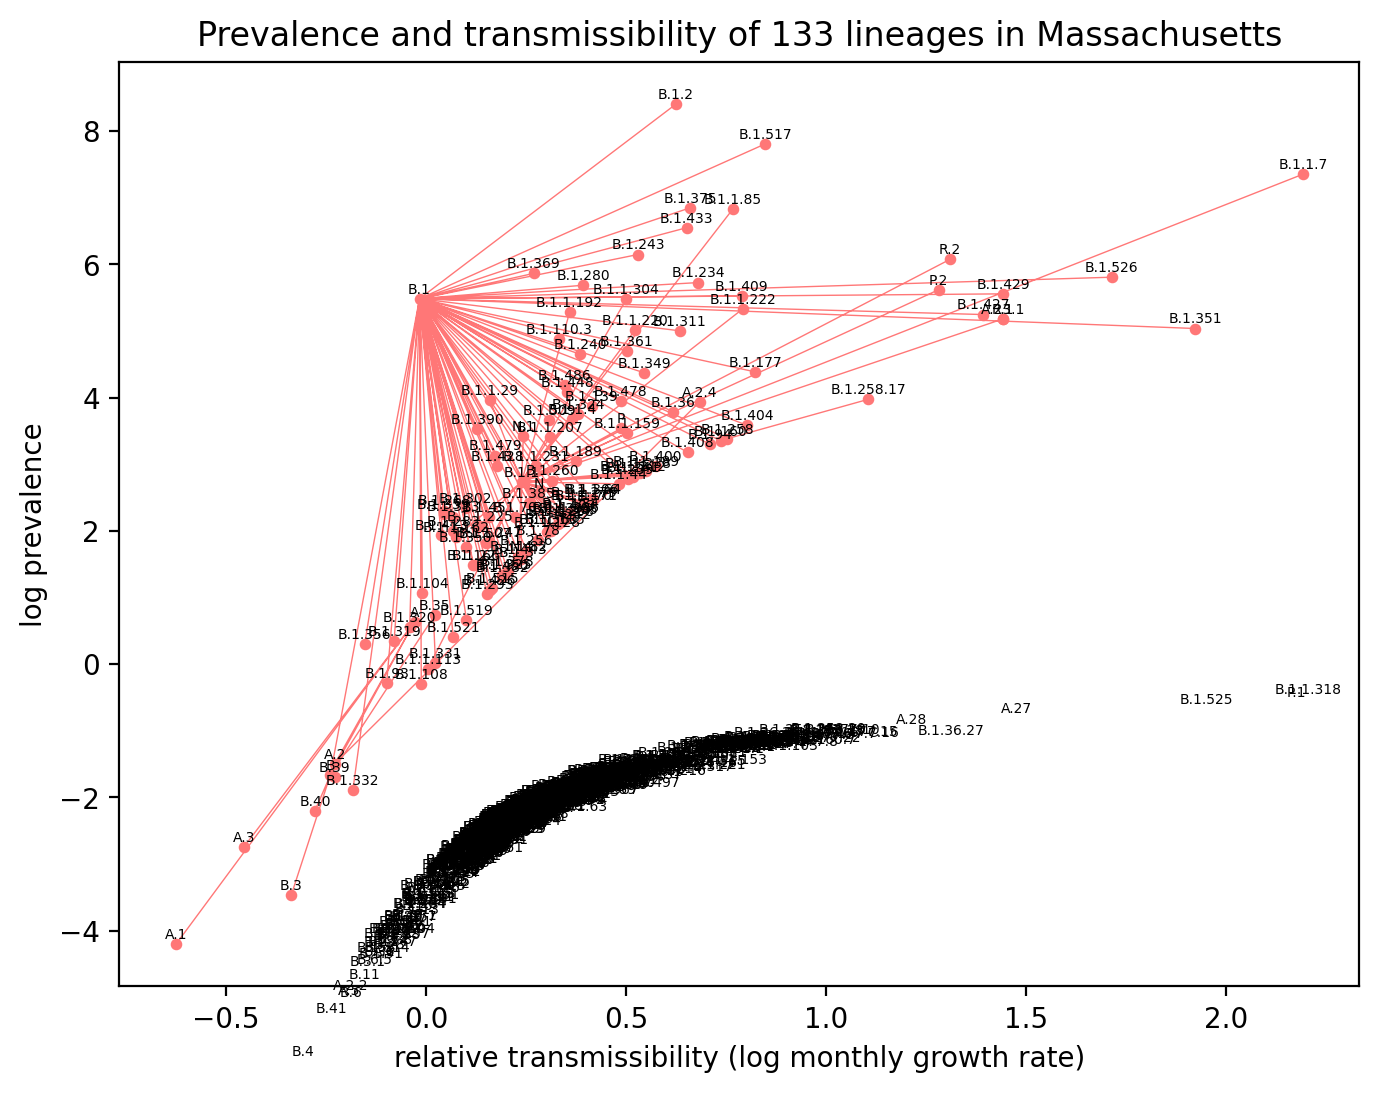

In [22]:
plot_prevalence("Massachusetts")

Finally we can use our logistic curves to forecast lineage prevalence in each region:

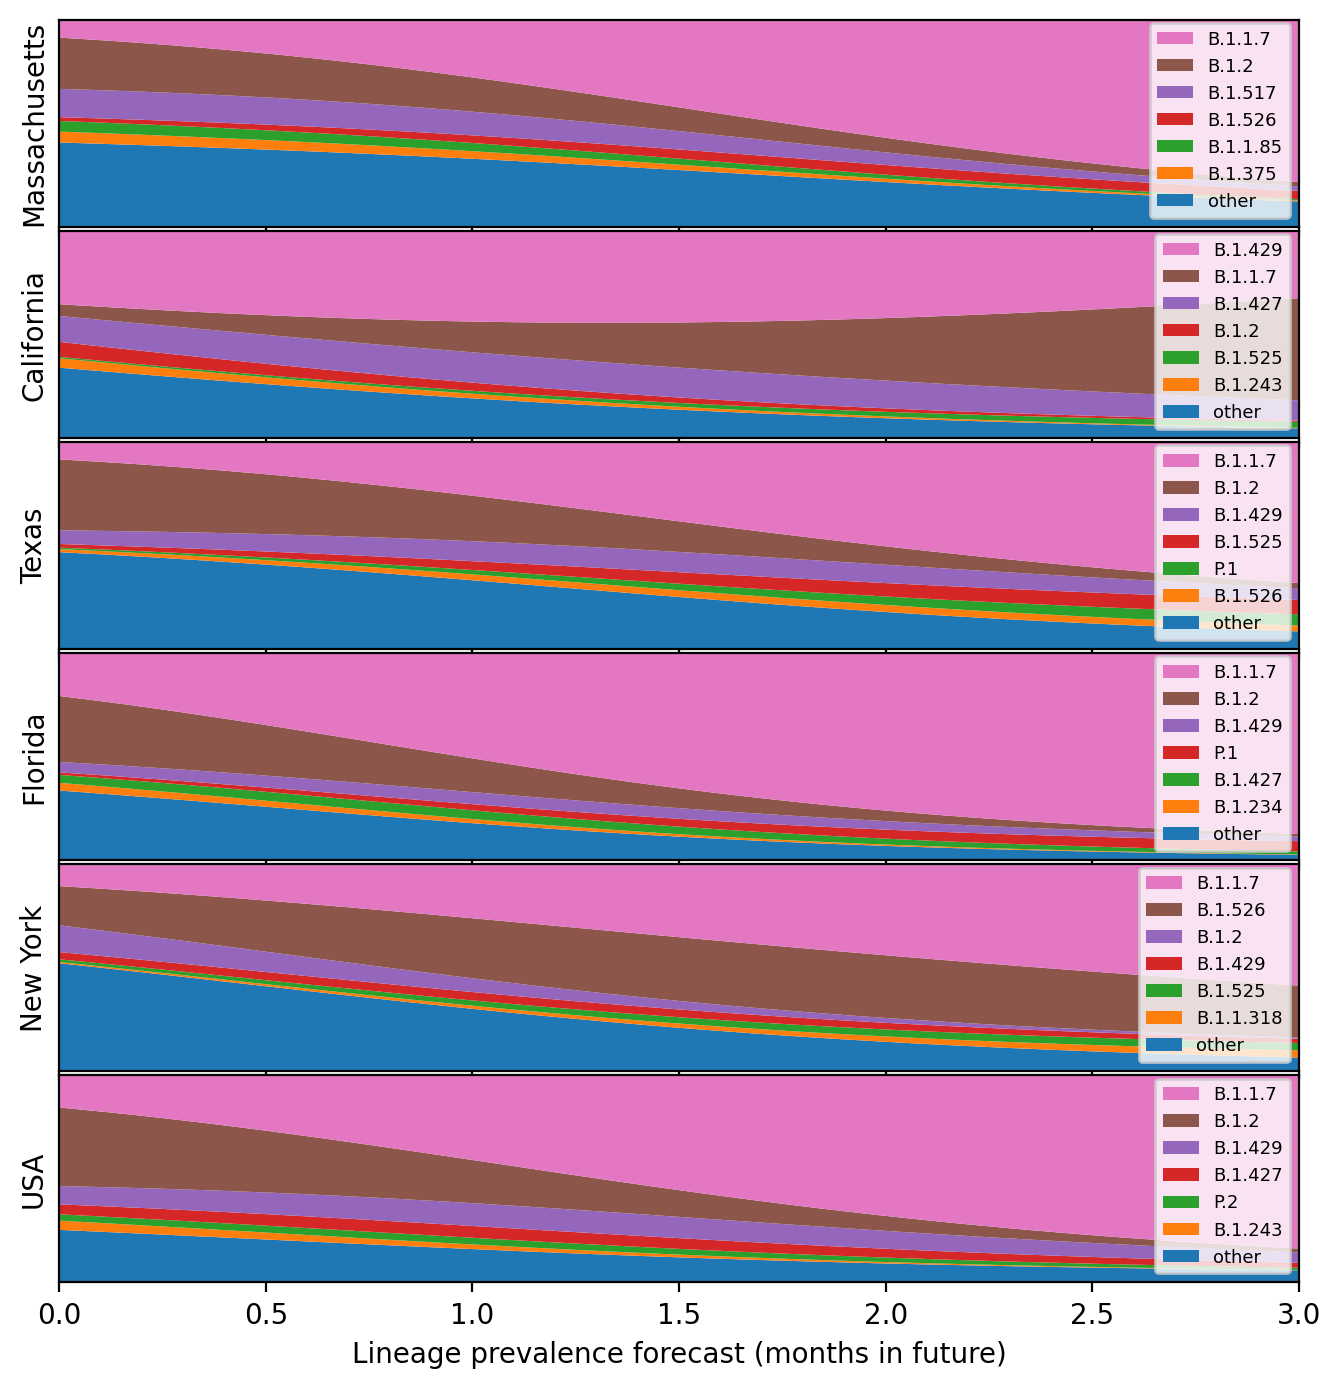

In [23]:
def plot_decomposition(queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        ids = [location_id[name] for name in names]
        assert ids, "no locations matching " + place_query
        log_rate = median["log_rate"]
        # FIXME this ignores region population when aggregating:
        log_init = median["log_init"][ids].logsumexp(0)
        assert log_init.shape == log_rate.shape
        time = torch.linspace(0, months_ahead / 12.0, 100)
        portion = (log_init + log_rate * time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(["Mass", "Calif", "Texas", "Florida", "New York", "USA"])